In [330]:
os.chdir('/home/mike/Desktop/Word Embeddings')
import os
import pandas as pd
import pickle
from gensim.models import Word2Vec
from random import randint

os.chdir('./Text Processing')
from TextPrep import TextPrep

os.chdir('../Meta Data')
from key_words import key_words, key_synonyms
from stop_words import stop_words
os.chdir('..')

In [553]:
def similar_words(word, model, topn):
    sim_words = []
    for i in range(topn):
        sim_words.append(model.wv.most_similar(word, topn = topn)[i][0])
    return sim_words + [word]

def similar_dict(words1, words2, labels):
    both = [word for word in words1 if word in words2]
    words1 = [word for word in words1 if word not in both]
    words2 = [word for word in words2 if word not in both]
    words = [words1, words2, both]
    labels = labels + ['Both']
    dictionary = {}
    for i in range(len(labels)):
        for word in words[i]:
            dictionary[word] = labels[i]
    return dictionary

def pca2df(pcamodel, embedding, dictionary):
    # convert the pca element to a df
    pc_df = pd.DataFrame(data = pcamodel, columns = ['pc1', 'pc2', 'pc3'])
    # add word column to the df
    pc_df['word'] = [key for key in embedding.wv.vocab]
    # get a list of unique words from the dictionary
    words = list(dictionary.keys())
    words = list(set(words))
    # keep only components that are in the list of unique words
    pc_df = pc_df[pc_df['word'].isin(words)].reset_index(drop=True)
    colors = {'Democrat': 'blue', 'Republican':'red', 'Both': 'purple', 'A': 'blue', 'B':'red'}
    pc_df['label'] = pc_df['word'].map(dictionary)
    pc_df['color'] = [colors[word] for word in pc_df['label']]
    return pc_df

In [562]:
# load in data
meta_data = pd.read_csv('Meta Data/meta_data.csv')
tweet_df = pd.read_csv('Data/aggregated_tweets.csv')
# subset to tweets after oct 29
tweet_df = tweet_df[tweet_df['created'] >= '2019-10-29']
# merge data with meta data
tweet_df = pd.merge(tweet_df, meta_data, how = 'inner', on = 'user_id')
tweet_df = tweet_df[tweet_df.party.isin(['R', 'D'])].reset_index(drop=True)

tweets = tweet_df['text']
labels = tweet_df['party']

# initialize parser
prep = TextPrep(stopwords = stop_words, key_words = key_words, key_synonyms = key_synonyms)

In [333]:
%%time
# preprocess text
tweets = [prep.twitter_preprocess(tweet) for tweet in tweets]


CPU times: user 421 ms, sys: 18 µs, total: 421 ms
Wall time: 420 ms


## Party Labels Trump

In [334]:
%%time
# tag keywords
ptrump_tweets = []
for i in range(len(tweets)):
    try:
        ptrump_tweets.append(prep.tag_keywords('trump', tweets[i], labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
ptrump_tweets = prep.multi_lemmatizer(ptrump_tweets, threads = 6)

CPU times: user 1min 10s, sys: 3.21 s, total: 1min 14s
Wall time: 24.4 s


In [351]:
# drop single letters
for i in range(len(ptrump_tweets)):
    ptrump_tweets[i] = [word for word in ptrump_tweets[i] if len(word) > 1]

In [555]:
%%time
# train word2vec
#ptrump_model = Word2Vec(ptrump_tweets, window = 10)

# assign data to variables
rtrump_words = similar_words('trump_r', ptrump_model, topn = 5)
dtrump_words = similar_words('trump_d', ptrump_model, topn = 5)
ptrump_sim = ptrump_similarity = ptrump_model.wv.similarity('trump_r', 'trump_d')
ptrump_dict = similar_dict(rtrump_words, dtrump_words, ['Republican', 'Democrat'])

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 11.3 ms


In [556]:
# fit pca model
data = ptrump_model[ptrump_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, ptrump_model, ptrump_dict)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


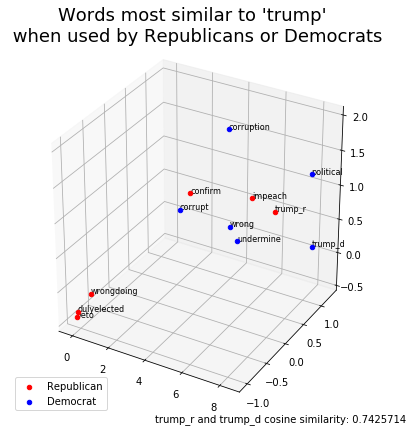

In [557]:
# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

for i in range(len(pc_df['word'])):
    x = pcdf.pc1[i]
    y = pcdf.pc2[i]
    z = pcdf.pc3[i]
    label = pcdf.word[i]
    ax.scatter(x, y, z, color=pcdf.color[i])
    ax.text(x, y, z, '%s' % (label), size=8, zorder=1, color='k')

plt.title('Words most similar to \'trump\' \n when used by Republicans or Democrats', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'trump_r and trump_d cosine similarity: ' + str(ptrump_sim), horizontalalignment='right')
plt.legend(pcdf.label.unique(), loc = 3)
plt.tight_layout()
plt.savefig('trump_party.png')
plt.show()

## Trump random labels

No handles with labels found to put in legend.


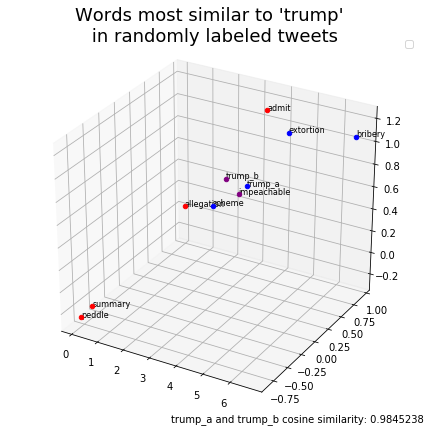

In [588]:
#pcdf
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

for i in range(len(pcdf['word'])):
    x = pcdf.pc1[i]
    y = pcdf.pc2[i]
    z = pcdf.pc3[i]
    label = pcdf.word[i]
    ax.scatter(x, y, z, color=pcdf.color[i])
    ax.text(x, y, z, '%s' % (label), size=8, zorder=1, color='k')

plt.title('Words most similar to \'trump\' \n in randomly labeled tweets', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'trump_a and trump_b cosine similarity: ' + str(rtrump_sim), horizontalalignment='right')
plt.legend()
plt.tight_layout()
plt.show()

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


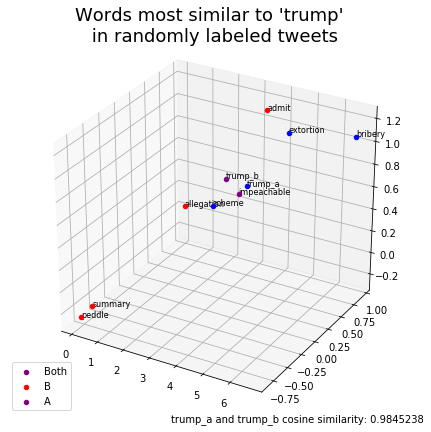

CPU times: user 1min 56s, sys: 7.5 s, total: 2min 4s
Wall time: 49.8 s


In [578]:
%%time
# generate random labels
rand_labels = [random.choice('ab') for label in labels]

# tag keywords with random labels and append to a list
rtrump_tweets = []
for i in range(len(tweets)):
    try:
        rtrump_tweets.append(prep.tag_keywords('trump', tweets[i], rand_labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize randomly tagged tweets
rtrump_tweets = prep.multi_lemmatizer(rtrump_tweets, threads = 6)

# drop single letters
for i in range(len(rtrump_tweets)):
    rtrump_tweets[i] = [word for word in rtrump_tweets[i] if len(word) > 1]
    
# train word2vec
rtrump_model = Word2Vec(rtrump_tweets, window = 10)

# Get top 5 words for each label
atrump_words = similar_words('trump_a', rtrump_model, topn = 5)
btrump_words = similar_words('trump_b', rtrump_model, topn = 5)
# get cosin similarity for key word
rtrump_sim = rtrump_model.wv.similarity('trump_a', 'trump_b')
# generate dictionary of most similar words and their appropriate labels
rtrump_dict = similar_dict(atrump_words, btrump_words, ['A', 'B'])

# fit pca model
data = rtrump_model[rtrump_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, rtrump_model, rtrump_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

for i in range(len(pcdf['word'])):
    x = pcdf.pc1[i]
    y = pcdf.pc2[i]
    z = pcdf.pc3[i]
    label = pcdf.word[i]
    ax.scatter(x, y, z, color=pcdf.color[i])
    ax.text(x, y, z, '%s' % (label), size=8, zorder=1, color='k')

plt.title('Words most similar to \'trump\' \n in randomly labeled tweets', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'trump_a and trump_b cosine similarity: ' + str(rtrump_sim), horizontalalignment='right')
plt.legend(pcdf.label.unique(), loc = 3)
plt.tight_layout()
plt.savefig('trump_rand.png')
plt.show()

## Test with random labels

In [150]:
%%time
# generate random labels
rand_labels = [str(randint(0,1)) for label in labels]

# tag tweets
rand_tweets = []
for i in range(len(tweets)):
    try:
        rand_tweets.append(prep.tag_keywords('trump', tweets[i], rand_labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
rand_tweets = prep.multi_lemmatizer(rand_tweets, threads = 6)

CPU times: user 5min 31s, sys: 16.2 s, total: 5min 47s
Wall time: 1min 57s


[['not',
  'long',
  'vote',
  'impeachment',
  'inquiry',
  'open',
  'transparent',
  'today',
  'h',
  're',
  'learn',
  'numerous',
  'closed',
  'deposition',
  'take',
  'place',
  'week',
  's',
  'surprising',
  'stoptheschiffshow'],
 ['look',
  'forward',
  'show',
  'repmarkgreen',
  'fl',
  'week',
  'amp',
  'introduce',
  'outstanding',
  'veteran',
  'community',
  'florida'],
 ['yes',
  'vote',
  'resolution',
  'give',
  'stamp',
  'approval',
  'process',
  'damage',
  'repair',
  'watch',
  'floor',
  'speech',
  'morning',
  'florida',
  'fl',
  'impeachmentinquiry'],
 ['house',
  'vote',
  'resolution',
  'formalize',
  'impeachmentinquiry',
  'trump_1',
  'damage',
  'clear',
  'democrat',
  'interested',
  'precedent',
  'process',
  'goal',
  'remove',
  'trump_1',
  'office',
  'period'],
 ['dc',
  'team',
  'happy',
  'help',
  'theuso',
  'afternoon',
  'total',
  'care',
  'package',
  'assemble',
  'deployed',
  'service',
  'member',
  'thank',
  'defend',

In [152]:
%%time
rand_model = Word2Vec(rand_tweets, window = 10)
rand_model.most_similar('trump_0')
rand_model.most_similar('trump_1')
rand_model.similarity('trump_0', 'trump_1')

CPU times: user 23.3 s, sys: 54.4 ms, total: 23.4 s
Wall time: 10.2 s


## PCA and visualization

In [160]:
rand_model.wv.vocab

{'not': <gensim.models.keyedvectors.Vocab at 0x7fa8c3c7a748>,
 'long': <gensim.models.keyedvectors.Vocab at 0x7fa8c3c7a518>,
 'vote': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5ac8>,
 'impeachment': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5ba8>,
 'inquiry': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5b38>,
 'open': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5be0>,
 'transparent': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5c18>,
 'today': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5c50>,
 'h': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5c88>,
 're': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5cc0>,
 'learn': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5cf8>,
 'numerous': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5d30>,
 'closed': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5d68>,
 'deposition': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5da0>,
 'take': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5dd8>,
 'place': <gensim.models.keyed

In [167]:
from sklearn.decomposition import PCA


/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


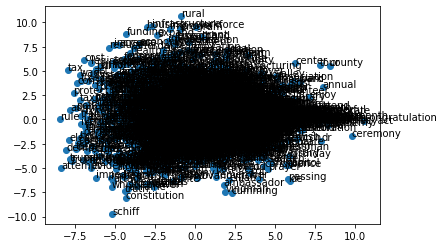

In [181]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
# define training data

# fit a 2d PCA model to the vectors
X = rand_model[rand_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(rand_model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [191]:
rand_model.wv.vocab['trump_0']

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


list

In [230]:
for i in range(5):
    print(i)

0
1
2
3
4


In [231]:
# function to return a list of strings for the most similar words. useful for labeling the scatter plot
def similar_words(word, model, topn):
    sim_words = []
    for i in range(topn):
        sim_words.append(model.most_similar(word, topn = topn)[i][0])
    return sim_words        

In [210]:
trump0_sim_words = []
for i in range(len(rand_model.most_similar('trump_0'))):
    trump0_sim_words.append(rand_model.most_similar('trump_0')[i][0])
    
trump0_sim_words.append('trump_0')
trump0_sim_words

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


['trump_1',
 'obama',
 'president',
 'untenable',
 'blatant',
 'corruption',
 'outrageous',
 'reckless',
 'exactly',
 'corrupt',
 'trump_0']

In [218]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [211]:
# subset the model to only the key word plus the most similar words
sub_rand_model = [rand_model[word] for word in trump0_sim_words]

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [251]:
result[0]

array([-5.2333336, -1.8067499], dtype=float32)

In [254]:
result.explained_variance_

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_'

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


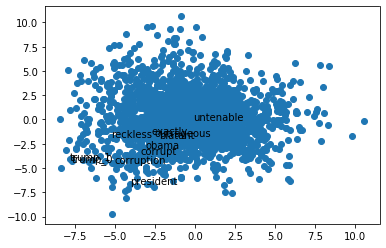

In [262]:
# 2d plot with labels
pca = PCA(n_components=2)
result = pca.fit_transform(rand_model[rand_model.wv.vocab])
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(rand_model.wv.vocab):
    if word in trump0_sim_words:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [270]:
pca.explained_variance_ratio_

array([0.11879037, 0.10206051, 0.07979332], dtype=float32)

In [541]:
# change words1 and words2 to a dictionary?
def pca2df(pcamodel, embedding, dictionary):
    # convert the pca element to a df
    pc_df = pd.DataFrame(data = pcamodel, columns = ['pc1', 'pc2', 'pc3'])
    # add word column to the df
    pc_df['word'] = [key for key in embedding.wv.vocab]
    # get a list of unique words from the dictionary
    words = list(dictionary.keys())
    words = list(set(words))
    # keep only components that are in the list of unique words
    pc_df = pc_df[pc_df['word'].isin(words)].reset_index(drop=True)
    colors = {'democrat': 'blue', 'republican':'red', 'Both': 'purple', 'A': 'blue', 'B':'red'}
    pc_df['label'] = pc_df['word'].map(dictionary)
    pc_df['color'] = [colors[word] for word in pc_df['label']]
    return pc_df

In [542]:
pca2df(result, ptrump_model, tdict)

,pc1,pc2,pc3,word,label,color
0,4.977250,0.749245,-0.104392,clear,democrat,blue
1,6.620352,0.610024,0.972961,try,democrat,blue
2,8.190639,1.047059,1.282021,political,democrat,blue
3,2.370237,0.382932,0.188497,interference,democrat,blue
4,3.392665,0.222725,1.047282,confirm,republican,red
5,3.284777,0.480185,0.894962,impeachable,republican,red
6,5.161929,0.998186,0.727809,impeach,republican,red
7,2.073626,0.193778,-0.120472,pre,democrat,blue
8,3.783914,1.270156,-0.167581,undermine,democrat,blue
9,4.906528,0.477292,1.948289,corruption,democrat,blue


In [531]:
tdict = similar_dict(rtrump_words, dtrump_words, ['republican', 'democrat'])
tdict

{'dulyelected': 'republican',
 'impeach': 'republican',
 'veto': 'republican',
 'confirm': 'republican',
 'wrongdoing': 'republican',
 'repadamschiff': 'republican',
 'kangaroocourt': 'republican',
 'evidence': 'republican',
 'obsession': 'republican',
 'impeachable': 'republican',
 'political': 'democrat',
 'wrong': 'democrat',
 'undermine': 'democrat',
 'corruption': 'democrat',
 'corrupt': 'democrat',
 'campaign': 'democrat',
 'pre': 'democrat',
 'interference': 'democrat',
 'clear': 'democrat',
 'try': 'democrat'}